# Carga y Preprocesamiento de los Datos - Preparación para Búsqueda de Modelo

La parte inicial de este código contiene el mismo obtenido del cuaderno `to-expose.ipynb`. Dado que en las instrucciones del desafío se indica un enfoque en la selección del modelo.

## Obtención y Procesamiento de Datos

In [130]:
#Se importan las librerías necesarias para el problema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msng
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
df = pd.read_csv('dataset_SCL.csv')

#### Generación de Columnas Adicionales
* **temporada_alta** : 1 si **Fecha-I** está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no

In [132]:
from datetime import datetime

def temporada_alta(fecha):
    fecha_año = int(fecha.split('-')[0])
    fecha = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
    range1_min = datetime.strptime('15-Dec', '%d-%b').replace(year = fecha_año)
    range1_max = datetime.strptime('31-Dec', '%d-%b').replace(year = fecha_año)
    range2_min = datetime.strptime('1-Jan', '%d-%b').replace(year = fecha_año)
    range2_max = datetime.strptime('3-Mar', '%d-%b').replace(year = fecha_año)
    range3_min = datetime.strptime('15-Jul', '%d-%b').replace(year = fecha_año)
    range3_max = datetime.strptime('31-Jul', '%d-%b').replace(year = fecha_año)
    range4_min = datetime.strptime('11-Sep', '%d-%b').replace(year = fecha_año)
    range4_max = datetime.strptime('30-Sep', '%d-%b').replace(year = fecha_año)
    
    if ((fecha >= range1_min and fecha <= range1_max) or 
        (fecha >= range2_min and fecha <= range2_max) or 
        (fecha >= range3_min and fecha <= range3_max) or
        (fecha >= range4_min and fecha <= range4_max)):
        return 1
    else:
        return 0
    
df['temporada_alta'] = df['Fecha-I'].apply(temporada_alta)
    

* **dif_min** : diferencia en minutos entre **Fecha-O** y **Fecha-I** .

In [17]:
def dif_min(data):
    fecha_o = datetime.strptime(data['Fecha-O'], '%Y-%m-%d %H:%M:%S')
    fecha_i = datetime.strptime(data['Fecha-I'], '%Y-%m-%d %H:%M:%S')
    dif_min = ((fecha_o - fecha_i).total_seconds())/60
    return dif_min

df['dif_min'] = df.apply(dif_min, axis = 1)

* **atraso_15** : 1 si **dif_min** > 15, 0 si no.

In [19]:
df['atraso_15'] = np.where(df['dif_min'] > 15, 1, 0)

* **periodo_dia** : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a **Fecha-I**.

In [21]:
def get_periodo_dia(fecha):
    fecha_time = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S').time()
    mañana_min = datetime.strptime("05:00", '%H:%M').time()
    mañana_max = datetime.strptime("11:59", '%H:%M').time()
    tarde_min = datetime.strptime("12:00", '%H:%M').time()
    tarde_max = datetime.strptime("18:59", '%H:%M').time()
    noche_min1 = datetime.strptime("19:00", '%H:%M').time()
    noche_max1 = datetime.strptime("23:59", '%H:%M').time()
    noche_min2 = datetime.strptime("00:00", '%H:%M').time()
    noche_max2 = datetime.strptime("4:59", '%H:%M').time()
    
    if(fecha_time > mañana_min and fecha_time < mañana_max):
        return 'mañana'
    elif(fecha_time > tarde_min and fecha_time < tarde_max):
        return 'tarde'
    elif((fecha_time > noche_min1 and fecha_time < noche_max1) or
         (fecha_time > noche_min2 and fecha_time < noche_max2)):
        return 'noche'
    
df['periodo_dia'] = df['Fecha-I'].apply(get_periodo_dia)

In [23]:
# df[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv', index = False)

## Evaluación de Modelos

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
data = shuffle(df[['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'atraso_15']], random_state = 111)

In [41]:
features = pd.concat([pd.get_dummies(data['OPERA'], prefix = 'OPERA'),pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), pd.get_dummies(data['MES'], prefix = 'MES')], axis = 1)
label = data['atraso_15']

In [42]:
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = 0.33, random_state = 42)

#### Utilizando Regresión logística

In [46]:
logReg = LogisticRegression()
model = logReg.fit(x_train, y_train)

In [47]:
y_pred = model.predict(x_test)

#### Métricas Regresión Logística

In [48]:
confusion_matrix(y_test, y_pred)

array([[18311,    92],
       [ 3985,   120]])

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     18403
           1       0.57      0.03      0.06      4105

    accuracy                           0.82     22508
   macro avg       0.69      0.51      0.48     22508
weighted avg       0.77      0.82      0.75     22508



#### Utilizando XGBoost - Mejores Parámetros del GridSearch Dado en `to-expose.ipynb`

En el cuaderno entregado, se realizó un GridSearch, a partir del cual los hiperparámetros correspondientes al mejor modelo fueron los siguientes:

- learning_rate: 0.1
- n_estimators: 100
- subsample: 0.5

In [50]:
import xgboost as xgb
from xgboost import plot_importance

In [115]:
modelxgb = xgb.XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=100, subsample=0.5)
modelxgb = modelxgb.fit(x_train, y_train)

[15:17:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [116]:
y_predxgb = modelxgb.predict(x_test)

#### Métricas XGBoost

In [117]:
confusion_matrix(y_test, y_predxgb)

array([[18314,    89],
       [ 3956,   149]])

In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     18403
           1       0.57      0.03      0.06      4105

    accuracy                           0.82     22508
   macro avg       0.69      0.51      0.48     22508
weighted avg       0.77      0.82      0.75     22508



### Utilizando Pesos para las Clases


Dado que este es un problema claramente desbalanceado, se va a configurar una penalización mayor para la función de error teniendo en cuenta el desbalanceo en favor de la clase 0 (vuelo no atrasado).

Se va a realizar esta prueba tanto para el modelo de Regresión Logística como para XGBoost.

##### Weighted Regresión Logística

In [139]:
logReg = LogisticRegression(class_weight='balanced')
logRegModel = logReg.fit(x_train, y_train)

In [140]:
y_pred = logRegModel.predict(x_test)

#### Métricas Weighted Regresión Logística

In [141]:
confusion_matrix(y_test, y_pred)

array([[10958,  7445],
       [ 1477,  2628]])

In [142]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.60      0.71     18403
           1       0.26      0.64      0.37      4105

    accuracy                           0.60     22508
   macro avg       0.57      0.62      0.54     22508
weighted avg       0.77      0.60      0.65     22508



##### Weighted XGBoost

In [82]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight( class_weight='balanced', y=y_train )

In [83]:
modelxgb = xgb.XGBClassifier(random_state=1, learning_rate=0.1, n_estimators=100, subsample=0.5)
modelxgb = modelxgb.fit(x_train, y_train, sample_weight=classes_weights)

[15:05:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [100]:
y_predxgb = modelxgb.predict(x_test)

#### Métricas Weighted XGBoost

In [101]:
confusion_matrix(y_test, y_predxgb)

array([[10856,  7547],
       [ 1431,  2674]])

In [103]:
print(classification_report(y_test, y_predxgb))

              precision    recall  f1-score   support

           0       0.88      0.59      0.71     18403
           1       0.26      0.65      0.37      4105

    accuracy                           0.60     22508
   macro avg       0.57      0.62      0.54     22508
weighted avg       0.77      0.60      0.65     22508



#### Utilizando Weighted XGBoost dejando Features más importantes

In [120]:
modelxgb.feature_importances_

array([0.01442984, 0.04489429, 0.04368213, 0.02526234, 0.02297895,
       0.04612988, 0.        , 0.01593831, 0.01523607, 0.07143058,
       0.03196954, 0.02773361, 0.01820382, 0.02135902, 0.01198903,
       0.03145238, 0.01285207, 0.05357669, 0.01655389, 0.04299838,
       0.03667367, 0.02446244, 0.03643163, 0.04080915, 0.        ,
       0.01833187, 0.01733475, 0.02868234, 0.02610512, 0.01428579,
       0.01424391, 0.0562302 , 0.01175342, 0.0171982 , 0.03244629,
       0.0199511 , 0.03638916], dtype=float32)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 936x720 with 0 Axes>

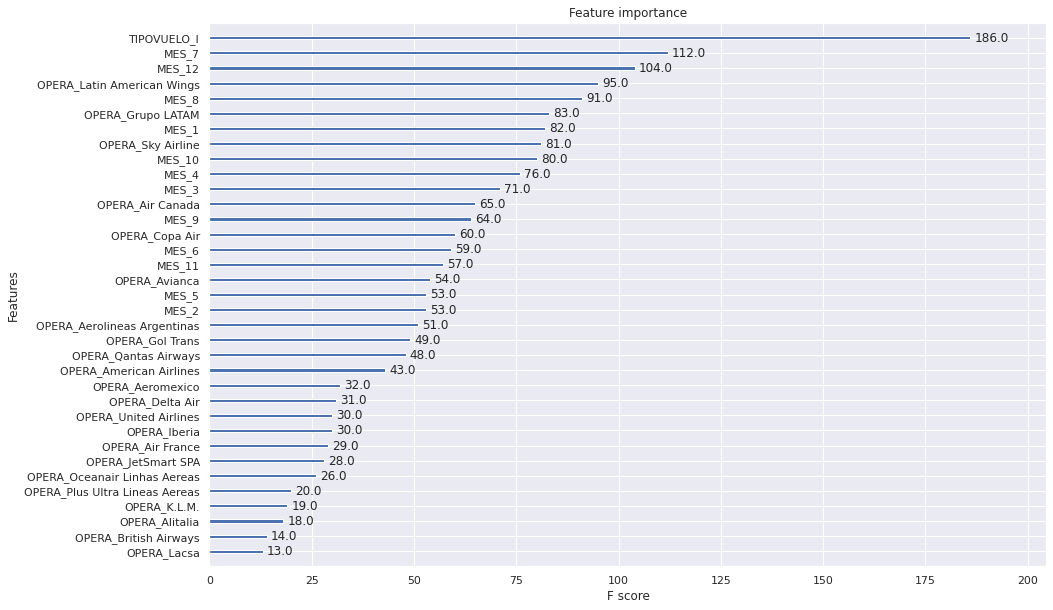

In [121]:
plt.figure(figsize = (13,10))
plot_importance(modelxgb)

In [122]:
features_importantes = features[['MES_7', 'TIPOVUELO_I', 'OPERA_Copa Air', 'OPERA_Latin American Wings',
                                'MES_12', 'OPERA_Grupo LATAM', 'MES_10', 'OPERA_JetSmart SPA', 'OPERA_Air Canada',
                                'MES_9', 'OPERA_American Airlines']]
labels_ = label

In [123]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(features_importantes, labels_, test_size = 0.33, random_state = 42)

In [126]:
modelxgb = xgb.XGBClassifier(random_state=1, learning_rate=0.01, subsample = 1, max_depth = 10)
modelxgb = modelxgb.fit(x_train2, y_train2, sample_weight=classes_weights)

[15:27:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [127]:
y_predxgb = modelxgb.predict(x_test2)

#### Métricas Weighted XGBoost dejando Features más importantes 

In [128]:
confusion_matrix(y_test2, y_predxgb)

array([[9217, 9186],
       [1217, 2888]])

In [129]:
print(classification_report(y_test2, y_predxgb))

              precision    recall  f1-score   support

           0       0.88      0.50      0.64     18403
           1       0.24      0.70      0.36      4105

    accuracy                           0.54     22508
   macro avg       0.56      0.60      0.50     22508
weighted avg       0.77      0.54      0.59     22508



## Selección Final de Modelo Teniendo en Cuenta Desbalanceo

Dado que el problema planteado provee unos datos desbalanceados, como es esperado, teniendo en cuenta que la situación más común debería ser el vuelo cumpliendo con los tiempos planeados; se utilizó un método correspondiente a la penalización a la función de error según el error que se cometió en la clasificación.

Se observa una considerable mejora en el f1-score, métrica de principal interés en este problema. Sin embargo, aún no parece ser un modelo lo suficientemente adecuado, y posiblemente se requieren más datos o descriptores relacionados con el retraso del itinerario de vuelo en un aeropuerto para llegar a una solución adecuada.

Por ahora, se seleccionará el modelo de Regresión Logística con pesos balanceados, debido a que es un modelo bastante simple y de fácil implementación en una REST API, permitiendo un tiempo de solicitud más corto.

### Guardado de Modelo en Archivo Pickle

In [146]:
import pickle5 as pickle

pickle.dump(logRegModel, open('model-files/pickle_model.pkl', 'wb'))